# Explore San Francisco Tech Meetups

## Prerequisites:
Add a Meetup API Key to your environment.
If you need a Meetup API Key you can fetch it from [here](https://secure.meetup.com/meetup_api/key/)

In [1]:
import datetime
import math
import meetup.api
import os
import pprint
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

%matplotlib inline

## Double check your environment

Nothing works without **MEETUP_API_KEY**.

In [2]:
assert 'MEETUP_API_KEY' in os.environ, (
    "You need a MEETUP_API_KEY in your environment please look at the "
    "README for instructions.")
client = meetup.api.Client()

## Categories

There are multiple categories of groups in Meetup, let's use Python's meetup.api to [GetCategories](https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCategories).

In [3]:
%%capture --no-display
categories = client.GetCategories()

### Exploring the response object

By looking at the **meta** member of the response, we can see that there are 33 different categories.

### What are the attributes of the response object?
We can find out by using __dict__ to get the attribute dictionary.

In [4]:
import json
categories.__dict__

{'results': [{'name': 'Arts & Culture',
   'sort_name': 'Arts & Culture',
   'id': 1,
   'shortname': 'Arts'},
  {'name': 'Book Clubs',
   'sort_name': 'Book Clubs',
   'id': 18,
   'shortname': 'Book Clubs'},
  {'name': 'Career & Business',
   'sort_name': 'Career & Business',
   'id': 2,
   'shortname': 'Business'},
  {'name': 'Cars & Motorcycles',
   'sort_name': 'Cars & Motorcycles',
   'id': 3,
   'shortname': 'Auto'},
  {'name': 'Community & Environment',
   'sort_name': 'Community & Environment',
   'id': 4,
   'shortname': 'Community'},
  {'name': 'Dancing', 'sort_name': 'Dancing', 'id': 5, 'shortname': 'Dancing'},
  {'name': 'Education & Learning',
   'sort_name': 'Education & Learning',
   'id': 6,
   'shortname': 'Education'},
  {'name': 'Fashion & Beauty',
   'sort_name': 'Fashion & Beauty',
   'id': 8,
   'shortname': 'Fashion'},
  {'name': 'Fitness', 'sort_name': 'Fitness', 'id': 9, 'shortname': 'Fitness'},
  {'name': 'Food & Drink',
   'sort_name': 'Food & Drink',
   'id

### First, let's look at the meta-data

In [5]:
def parse_meta(response):
    return pd.DataFrame.from_dict(response.meta, orient='index')

cat_meta_df = parse_meta(categories)
cat_meta_df

,0
next,
method,Categories
total_count,33
link,https://api.meetup.com/2/categories
count,33
description,Returns a list of Meetup group categories
lon,None
title,Categories
url,https://api.meetup.com/2/categories?offset=0&f...
id,


### Secondly, let's take a look at the categories themselves

In [6]:
def parse_results(response):
    return pd.DataFrame.from_dict(response.results)

cats_df = parse_results(categories)
cats_df

,id,name,shortname,sort_name
0,1,Arts & Culture,Arts,Arts & Culture
1,18,Book Clubs,Book Clubs,Book Clubs
2,2,Career & Business,Business,Career & Business
3,3,Cars & Motorcycles,Auto,Cars & Motorcycles
4,4,Community & Environment,Community,Community & Environment
5,5,Dancing,Dancing,Dancing
6,6,Education & Learning,Education,Education & Learning
7,8,Fashion & Beauty,Fashion,Fashion & Beauty
8,9,Fitness,Fitness,Fitness
9,10,Food & Drink,Food & Drink,Food & Drink


### So, if we want to work with a particular category
In our case 'Tech'...

In [7]:
tech_df = cats_df.loc[cats_df['name'] == 'Tech']
tech_df

,id,name,shortname,sort_name
31,34,Tech,Tech,Tech


### Let's go ahead and store the ID number for later reference

In [8]:
tech_category_id = tech_df['id'].values[0]
tech_category_id

34

## Explore Cities
### Now let's look at cities in the United States named San Francisco

In [9]:
%%capture --no-display
cities_resp = client.GetCities(country='United States', query='San Francisco')

In [10]:
cities_meta_df = parse_meta(cities_resp)
cities_meta_df

,0
next,
method,Cities
total_count,10
link,https://api.meetup.com/2/cities
count,10
description,Returns Meetup cities. This method supports se...
lon,None
title,Cities
url,https://api.meetup.com/2/cities?offset=0&query...
id,


### Hmm. Why are there 10 cities?

In [11]:
cities_df = parse_results(cities_resp)
cities_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101
1,Bosque,us,87006,34.560001,USA,-106.779999,5,"San Francisco, New Mexico, USA",1,NM,87006
2,San Luis,us,81152,37.080002,USA,-105.620003,4,"San Francisco, Colorado, USA",2,CO,81152
3,San Francisco de Macorís,do,1009671,19.299999,Dominican Republic,-70.250000,4,"San Francisco de Macorís, Dominican Republic",3,NaN,meetup6
4,Reserve,us,87830,33.650002,USA,-108.769997,1,"San Francisco Plaza, New Mexico, USA",4,NM,87830
5,San Francisco de Yojoa,hn,1016115,15.020000,Honduras,-87.970001,1,"San Francisco de Yojoa, Honduras",5,NaN,meetup213
6,San Francisco del Mar,mx,1028671,16.230000,Mexico,-94.650002,1,"San Francisco del Mar, Mexico",6,NaN,meetup1676
7,San Francisco Menéndez,sv,1038344,13.850000,El Salvador,-90.019997,0,"San Francisco Menéndez, El Salvador",7,NaN,meetup110
8,San Francisco,ar,1111239,-31.430000,Argentina,-62.080002,0,"San Francisco, Argentina",8,NaN,meetup95
9,San Francisco El Alto,gt,1015524,14.950000,Guatemala,-91.449997,0,"San Francisco El Alto, Guatemala",9,NaN,meetup24


### Let's filter the dataframe to just cities in California, US

In [12]:
single_city_df = cities_df.loc[
    (cities_df['state'] == 'CA') & 
    (cities_df['country'] == 'us')]

single_city_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101


### And store the latitude and longitude for later

In [13]:
latitude = single_city_df['lat'].values[0]
longitude = single_city_df['lon'].values[0]
latitude, longitude

(37.779998779296875, -122.41999816894531)

## Explore Groups

In [14]:
%%capture --no-display
def get_a_group(page_number, category_id=tech_category_id, lat=latitude,
               lon=longitude):
    return client.GetGroups(
        category_id=category_id, lat=lat, lon=lon, offset=page_number)

group_resp = get_a_group(0)

In [15]:
group_meta = parse_meta(group_resp)
total_count = group_resp.meta['total_count']
count = group_resp.meta['count']
page_count = math.ceil(total_count / count)
group_meta

,0
next,https://api.meetup.com/2/groups?offset=1&forma...
method,Groups
total_count,2181
link,https://api.meetup.com/2/groups
count,200
description,None
lon,-122.42
title,Meetup Groups v2
url,https://api.meetup.com/2/groups?offset=0&forma...
id,


In [17]:
first_page_df = parse_results(group_resp)
first_page_df.head(1)

,category,city,country,created,description,group_photo,id,join_mode,lat,link,...,name,organizer,rating,state,timezone,topics,urlname,utc_offset,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",San Francisco,US,1034097740000,<p>The SF PHP Community Meetup is an open foru...,{'highres_link': 'https://secure.meetupstatic....,120903,open,37.77,https://www.meetup.com/sf-php/,...,SF PHP Community,"{'member_id': 126468982, 'name': 'Andre Marigo...",4.38,CA,US/Pacific,"[{'urlkey': 'php', 'name': 'PHP', 'id': 455}, ...",sf-php,-28800000,public,PHP Developers


### That's too many columns
I think I'll limit my columns to just what I care about

In [18]:
column_list = ['id', 'name', 'members', 'rating', 'join_mode', 'urlname']
first_page_df = first_page_df[column_list]
first_page_df.head(1)

,id,name,members,rating,join_mode,urlname
0,120903,SF PHP Community,2694,4.38,open,sf-php


---
## Explore Members

### Let's start with with a histogram

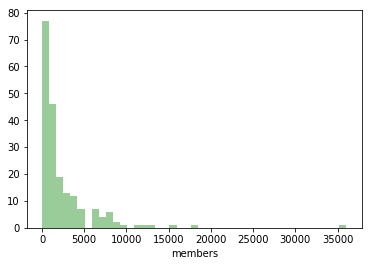

In [19]:

sb.distplot(first_page_df['members'], kde=False, color="g");

# You could also use pandas, but I prefer seaborn visualizations
# first_page_df['members'].plot.hist()

### Seems like most groups have fewer than 1,000 members

However, there are a few outliers, including one at over 35,000 members!
Let's take a closer look at our first page of 200 groups with a table of stats:


In [20]:
pd.options.display.float_format = '{:20,.2f}'.format
first_page_df.describe()

,id,members,rating
count,200.00,200.00,200.00
mean,"1,465,628.10","2,435.80",4.56
std,"440,282.26","3,754.88",0.43
min,"107,604.00",5.00,0.00
25%,"1,325,338.00",431.00,4.49
50%,"1,597,032.00","1,148.00",4.63
75%,"1,736,028.50","2,912.50",4.72
max,"2,233,791.00","36,048.00",5.00


Ah, strike that the lower 50% of the groups have 1,148 or fewer members.

Also there's a group with 5 members on the low end and **36,000+ members on the high end**!
The average is 1,148 members.  The largest group is definitely an outlier.

### Maybe a whisker plot can visualize these stats for us

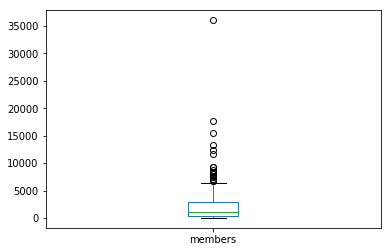

In [21]:
first_page_df['members'].plot.box();

---

Yeah, the outlier is way out there!  Look how far away it is from the 75 percentile
mark at the top of the box (2,912 members).

## Getting all Tech Meetup Groups

Let's grab the remaining groups and place them into a big dataframe for further
analysis

In [22]:
%%capture --no-display
from tqdm import tnrange, tqdm_notebook
page_df_list = [first_page_df] # we already have the first page

for i in tnrange(1, page_count):
    frame = parse_results(get_a_group(i))
    frame = frame[column_list]
    page_df_list.append(frame)

big_df = pd.concat(page_df_list, ignore_index=True)
big_df

,id,name,members,rating,join_mode,urlname
0,120903,SF PHP Community,2694,4.38,open,sf-php
1,134063,The San Francisco Ruby Meetup Group,6000,4.60,open,sfruby
2,107604,#SFMySQL Meetup,2585,4.44,open,sf-mysql
3,221293,San Francisco Tech4Good,4843,4.60,approval,sftech4good
4,228852,SF New Tech,8327,4.55,open,sfnewtech
5,230033,The San Francisco Bay Area PostgreSQL Meetup G...,1560,4.58,open,postgresql-1
6,245298,Silicon Valley Ruby on Rails,2577,4.55,open,rubymeetup
7,291864,Blockchain Founder Club SF/SV,6951,4.63,open,Founder
8,310796,The East Bay Ruby Meetup Group,1829,4.45,open,EBRuby
9,321601,SF Beta: Startup Mixers,2242,4.25,open,sfbeta


In [23]:
print(f"Size of our dataframe: {len(big_df)}, Expected size: {total_count}")
assert len(big_df) == total_count, "Something went wrong"

Size of our dataframe: 2181, Expected size: 2181


---

### Let's take a look at the full data set


In [24]:
big_df.describe()

,id,members,rating
count,"2,181.00","2,181.00","2,181.00"
mean,"19,138,365.22",815.63,2.76
std,"9,278,758.62","1,744.00",2.34
min,"107,604.00",1.00,0.00
25%,"13,584,402.00",88.00,0.00
50%,"19,973,429.00",258.00,4.48
75%,"27,302,708.00",782.00,4.84
max,"31,182,471.00","36,048.00",5.00


Well now, it looks like the first 200 groups were not representative of the
whole.  It seems like 50% of the groups **actually** have 258 or fewer members!  

And that top group is still out there at 36,000+ members!

### Now for the new box plot

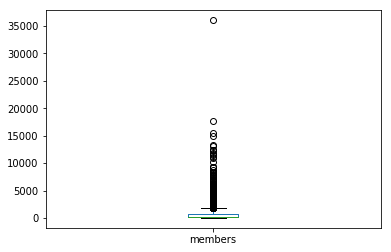

In [25]:
big_df['members'].plot.box();

### Yes, the outliers are way further out relative to our box plot

With the new data in place, I have to wonder about the outliers.  Why are the groups so big?

In fact...

### What are the 10 biggest tech groups in the area?

In [26]:
biggest_ten_df = big_df.sort_values('members', ascending=False).head(10)
biggest_ten_df

,id,name,members,rating,join_mode,urlname
19,844726,Silicon Valley Entrepreneurs & Startups,36048,4.58,open,sventrepreneurs
107,1619955,SFHTML5,17643,4.67,open,sfhtml5
106,1615633,Designers + Geeks,15425,4.46,open,designersgeeks
426,9226282,SF Data Science,14863,4.49,open,SF-Data-Science
28,1060260,The SF JavaScript Meetup,13352,4.54,open,jsmeetup
250,3483762,Tech in Motion Events: San Francisco,13075,4.48,approval,TechinMotionSF
540,13402242,Docker Online Meetup,12472,4.37,open,Docker-Online-Meetup
191,2065031,SF Data Mining,12376,4.64,open,Data-Mining
201,2252591,Women Who Code SF,12320,4.78,open,Women-Who-Code-SF
705,18354966,SF Big Analytics,11845,4.53,open,SF-Big-Analytics


## Get Group Events

### We need to do some data shaping before the next api call

Mostly we need to:
1.  pass in a string with group ids from our 10 biggest groups
2.  convert our human-readable date ranges to milliseconds since Jan 1, 1970
3.  Call the GetEvents API filtering for past events using our group IDs and our date range

#### First, let's make that string of group ids


In [27]:
id_list = biggest_ten_df['id'].tolist()
id_list
ids = ','.join(str(x) for x in id_list)
ids

'844726,1619955,1615633,9226282,1060260,3483762,13402242,2065031,2252591,18354966'

#### Now, let's get the epoch milliseconds for a date range between now and 9 months ago

In [28]:
def to_millis(dt):
    return int(pd.to_datetime(dt).value / 1000000)

this_ms = to_millis(datetime.datetime.now())
nine_months_ago = int(this_ms - 180 * 24 * 60 * 60 * 1000)
print(f"Now: {this_ms}, nine months ago: {nine_months_ago}")

Now: 1550466832240, nine months ago: 1534914832240


#### Finally, let's look at those events.

In [29]:
%%capture --no-display
events_resp = client.GetEvents(group_id=ids, status='past',
                               time=f"{nine_months_ago},{this_ms}");

In [30]:
parse_meta(events_resp)

,0
next,
method,Events
total_count,107
link,https://api.meetup.com/2/events
count,107
description,"Access Meetup events using a group, member, or..."
lon,
title,Meetup Events v2
url,https://api.meetup.com/2/events?offset=0&forma...
id,


### Again, our raw results dataframe has extra columns that I don't care about

In [31]:
raw_results_df = parse_results(events_resp)
raw_results_df.head(1)

,created,description,duration,event_url,group,headcount,how_to_find_us,id,maybe_rsvp_count,name,...,rating,rsvp_limit,status,time,updated,utc_offset,venue,visibility,waitlist_count,yes_rsvp_count
0,1533618857000,<p>Navigating your Coding Career in Silicon Va...,9000000,https://www.meetup.com/Women-Who-Code-SF/event...,"{'join_mode': 'open', 'created': 1311875189000...",0,NaN,253571692,0,Navigating your Coding Career in Silicon Valley,...,"{'count': 0, 'average': 0}",nan,past,1534984200000,1534997800000,-25200000,"{'zip': '94107', 'country': 'us', 'localized_c...",public,0,86


## So let's limit it to a number that I actually can use

In [36]:
raw_results_df = parse_results(events_resp)
column_list = ['group', 'time', 'created', 'updated', 'duration',
               'yes_rsvp_count']
raw_results_df = raw_results_df[column_list]
raw_results_df.head(1)

,group,time,created,updated,duration,yes_rsvp_count
0,"{'join_mode': 'open', 'created': 1311875189000...",1534984200000,1533618857000,1534997800000,9000000,86


### Hmm.  Lot's of information in the group object

I only need to unpack the **id** from the **group** object, let's do that now.

In [37]:
def get_id(my_dict):
    return my_dict["id"]

raw_results_df["id"] = raw_results_df["group"].apply(get_id)

columns = ['id', 'time', 'duration', 'yes_rsvp_count']
raw_results_df = raw_results_df[columns]
raw_results_df.head(1)

,id,time,duration,yes_rsvp_count
0,2252591,1534984200000,9000000,86


### Now it seems that our time fields is in epoch milliseconds

Let's add a human-readable equivalent to the data frame.

In [38]:
for field in ["time"]:
    raw_results_df[field+"_dt"] = pd.to_datetime(raw_results_df[field],
                                                 unit='ms')
columns = ['id', 'time','time_dt', 'duration', 'yes_rsvp_count']
raw_results_df = raw_results_df[columns]
raw_results_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,2252591,1534984200000,2018-08-23 00:30:00,9000000,86


### Let's make our duration easier to read by converting it from milliseconds

It's easier for humans to read days, hours, and minutes.

In [39]:
def convert_to_d_h_m_s(ms):
    """Return the tuple of days, hours, minutes and seconds."""
    seconds = ms / 1000
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)

    return f"{days} days, {hours} hours, {minutes} minutes" 

raw_results_df["duration"] = raw_results_df["duration"].apply(
    convert_to_d_h_m_s)

raw_results_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,2252591,1534984200000,2018-08-23 00:30:00,"0.0 days, 2.0 hours, 30.0 minutes",86


## Now let's join our top ten groups dataframe with our events dataframe

If you are familiar with SQL this is similar to a left join from **raw_results_df**
to **biggest_ten_df** on **id**

Then we sort the output by **name** ascending and then **time** descending.

In [41]:
# lets merge in the group names

merged_df = pd.merge(
    raw_results_df,
    biggest_ten_df[['id', 'name']],
    on='id',
    how='left')

columns = ['name', 'time', 'time_dt', 'duration', 'yes_rsvp_count']
final_df = merged_df[columns]

# And then sort the output by name and time
final_df.sort_values(by=['name', 'time'], ascending=[True, False])

,name,time,time_dt,duration,yes_rsvp_count
61,Designers + Geeks,1542337200000,2018-11-16 03:00:00,"0.0 days, 2.0 hours, 0.0 minutes",71
52,Designers + Geeks,1541124000000,2018-11-02 02:00:00,"0.0 days, 2.0 hours, 0.0 minutes",71
38,Designers + Geeks,1539914400000,2018-10-19 02:00:00,"0.0 days, 2.0 hours, 0.0 minutes",41
30,Designers + Geeks,1538704800000,2018-10-05 02:00:00,"0.0 days, 2.0 hours, 0.0 minutes",29
20,Designers + Geeks,1537495200000,2018-09-21 02:00:00,"0.0 days, 2.0 hours, 0.0 minutes",37
10,Designers + Geeks,1536285600000,2018-09-07 02:00:00,"0.0 days, 2.0 hours, 0.0 minutes",87
46,Docker Online Meetup,1540915200000,2018-10-30 16:00:00,"0.0 days, 1.0 hours, 0.0 minutes",1
103,SF Big Analytics,1549591200000,2019-02-08 02:00:00,"0.0 days, 2.0 hours, 30.0 minutes",418
86,SF Big Analytics,1547690400000,2019-01-17 02:00:00,"0.0 days, 3.0 hours, 0.0 minutes",450
84,SF Big Analytics,1547604000000,2019-01-16 02:00:00,"0.0 days, 3.0 hours, 0.0 minutes",5


### Ah, this is interesting

From the top 10 groups I can see that some groups like **SF Data Science** meet pretty regularly, and their attendance is pretty consistent.  

Let's take a closer look at just this group

In [42]:
interesting_group_df = final_df[final_df['name'] == "SF Data Science"]
interesting_group_df

,name,time,time_dt,duration,yes_rsvp_count
32,SF Data Science,1539306000000,2018-10-12 01:00:00,"0.0 days, 3.0 hours, 0.0 minutes",15
36,SF Data Science,1539910800000,2018-10-19 01:00:00,"0.0 days, 2.0 hours, 0.0 minutes",95
44,SF Data Science,1540774800000,2018-10-29 01:00:00,"0.0 days, 4.0 hours, 0.0 minutes",21
58,SF Data Science,1542211200000,2018-11-14 16:00:00,"0.0 days, 10.0 hours, 0.0 minutes",1
66,SF Data Science,1543539600000,2018-11-30 01:00:00,"0.0 days, 3.0 hours, 30.0 minutes",18
87,SF Data Science,1547692200000,2019-01-17 02:30:00,"0.0 days, 2.0 hours, 0.0 minutes",59
88,SF Data Science,1547778600000,2019-01-18 02:30:00,"0.0 days, 2.0 hours, 0.0 minutes",26
95,SF Data Science,1548383400000,2019-01-25 02:30:00,"0.0 days, 2.0 hours, 0.0 minutes",48
99,SF Data Science,1548988200000,2019-02-01 02:30:00,"0.0 days, 2.0 hours, 0.0 minutes",94


### A simple line plot shows us something

This is nice, but what is the trend, is the group active?  It's tough to tell
from a simple line plot.

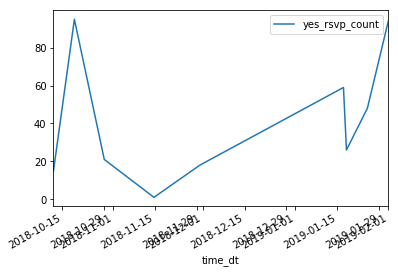

In [43]:
lines = interesting_group_df[['time_dt', 'yes_rsvp_count']].plot(
    kind='line', x='time_dt', y='yes_rsvp_count')

### Let's get a trendline

Let's see the trend using a seaborn regplot.  I'll use the milliseconds 
since the epoch, since it is numeric and can be used to generate a trend line.

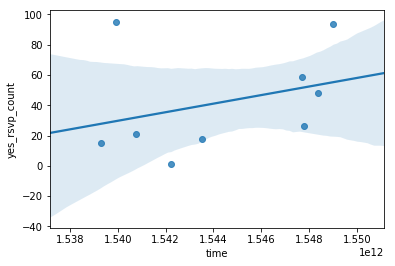

In [44]:
%%capture --no-display

#interesting_group_df
sb.regplot(x='time', y='yes_rsvp_count', data=interesting_group_df);

## Conclusion

It seems that the **SF Data Science** is one of the 10 biggest technology meetup groups in the San Francisco Area.  Over the past nine months, more and more people are RSVP-ing yes to their events, which occur every few weeks.  If data science is your thing and you live in the San Francisco Bay area, you will probably find a larger, more active group here.  